# Problem description:
Our business goal is to maximize the Life Span (LS) of one of our consumables (Consumable A), which is measured in cycles. 
Average LS today is about 9,500 cycles. Our main concern is when the Consumable lives less than 5,000 cycles.

We suspect that several physical parameters in the printing press might contribute to or harm Consumable A LS.

The relevant parameters are: Temperature at location 1 (Temp@1), Temperature at location 2 (Temp@2), flow, dirtiness, filter pressure.

The current set point (target value) for Temp@1 is 280 (28.0˚) and for Temp@2 is 250 (25.0˚).

The parameters are all measured and recorded several times throughout the Consumable life. Measurements should be registered approximately every 2,000 cycles (may be more frequently), so each consumable has several readings.

In addition, we have 20 press types in a field, each type has different LS distribution for Consumable A.


### We are being asked for insights as to how to optimize our Consumable A LS, for all press types.



## Data:
2 data sets are given:
* <b> LS data for Consumable A with the following parameters:</b>
    - Press number
    - Consumable Removal_dateTime
    - Consumable Install_datetime
    - Consumable ID
    - Consumable LS (Printed cycles)
    - Press type

<u> Important notes: </u> When the consumable is removed it can’t be re-installed again (single usage). Printing can only occur when a consumable of type A is installed on the press (so when one is removed, another must immediately be installed) and print cycles only increase when the press prints. 

* <b> Parameter measurements with the following parameters: </b>
    - Press Number
    - event_datetime
    - Temp@1
    - Temp@2
    - Flow
    - Dirtiness
    - filter_pressure 


## The Assignment 

1.	Join the data sets in a meaningful way to allow analyzing the effects of the physical parameters on consumable A lifespan. 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.utils import class_weight
from sklearn.metrics import mean_squared_error,r2_score,explained_variance_score,mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score,v_measure_score,silhouette_score
warnings.filterwarnings('ignore')
plt.close('all')

In [2]:
df_LS=pd.read_csv("LS data for consumable A.csv")
df_LS = df_LS.drop_duplicates()
df_Param=pd.read_csv("Parameter Measurements1.csv")
df_Param=df_Param.sort_values(by=[df_Param.columns[0],df_Param.columns[1]])
df_Param = df_Param.drop_duplicates()
Param_length=len(df_Param)

In [3]:
df_Param.head()

,Press Number,event_datetime,Temp@1,Temp@2,flow,dirtiness,filter_pressure
273469,921000012,2021/10/03 7:56:53.000 AM,272,282,4308,803,879
273470,921000012,2021/10/25 10:07:49.000 AM,277,291,4248,803,1022
5188,921000015,2021/09/01 10:25:17.000 AM,279,260,4458,674,424
5189,921000015,2021/09/01 10:57:55.000 AM,270,256,4410,674,426
3866,921000015,2021/09/01 12:14:48.000 PM,271,260,4428,674,427


In [4]:
df_Param.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 732257 entries, 273469 to 690880
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   Press Number     732257 non-null  int64 
 1   event_datetime   732257 non-null  object
 2   Temp@1           732257 non-null  int64 
 3   Temp@2           732257 non-null  int64 
 4   flow             732257 non-null  object
 5   dirtiness        732257 non-null  int64 
 6   filter_pressure  732203 non-null  object
dtypes: int64(4), object(3)
memory usage: 44.7+ MB


In [5]:
df_Param=df_Param.replace(['not available','NULL'],np.nan,regex=True)
df_LS=df_LS.replace(['not available','NULL'],np.nan,regex=True)
df_Param["flow"]=pd.to_numeric(df_Param.flow)
df_Param["filter_pressure"]=pd.to_numeric(df_Param.filter_pressure)

In [6]:
df_Param.describe()

,Press Number,Temp@1,Temp@2,flow,dirtiness,filter_pressure
count,7.322570e+05,732257.000000,732257.000000,652568.000000,732257.000000,506882.000000
mean,9.265212e+08,289.288677,262.320642,4276.491992,874.083547,595.959705
std,2.360113e+06,20.737018,30.720467,640.639197,180.748190,514.641487
min,9.210000e+08,-37.000000,0.000000,0.000000,0.000000,-90.000000
25%,9.240004e+08,275.000000,241.000000,4086.000000,775.000000,196.000000
50%,9.280003e+08,283.000000,258.000000,4248.000000,949.000000,548.000000
75%,9.283000e+08,301.000000,280.000000,4404.000000,1000.000000,877.000000
max,9.285015e+08,403.000000,453.000000,126444.000000,1062.000000,5243.000000


In [7]:
#Physical properties shouldn't be negetive, therefore all temps from 0 and bellow should be dropped.
df_Param = df_Param.drop(df_Param[df_Param["Temp@1"] < 0].index)
df_Param = df_Param.drop(df_Param[df_Param["filter_pressure"] < 0].index)
df_Param["Temp@1"]=df_Param["Temp@1"]/10
df_Param["Temp@2"]=df_Param["Temp@2"]/10

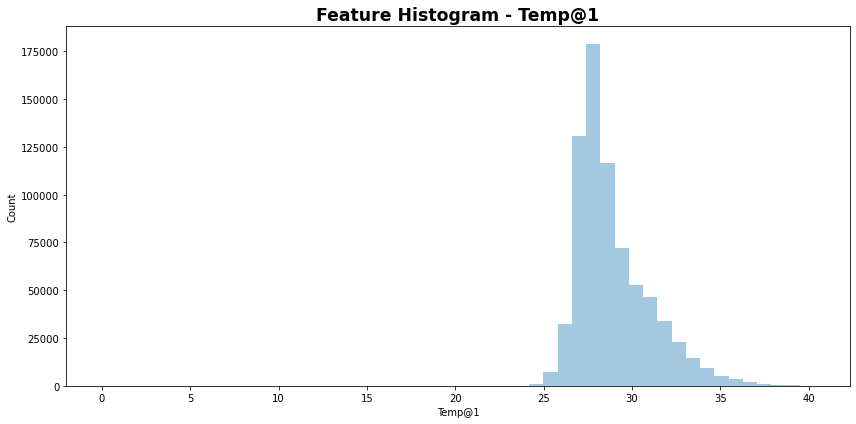

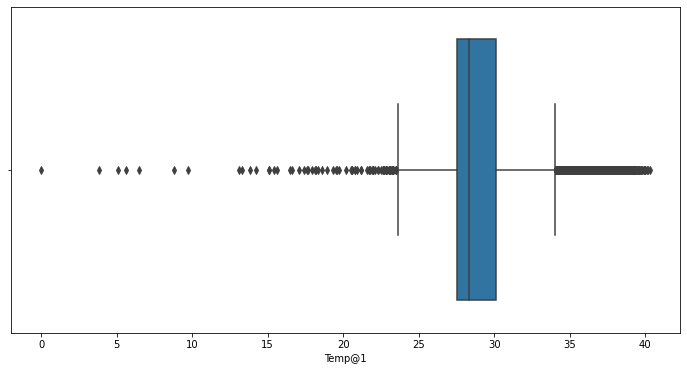

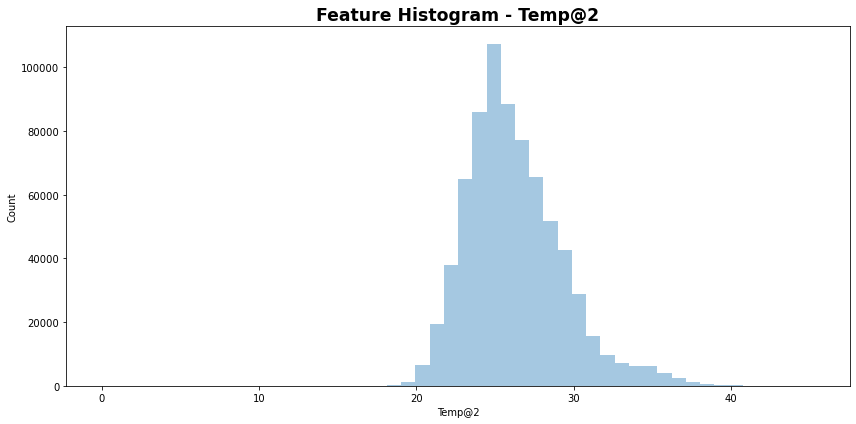

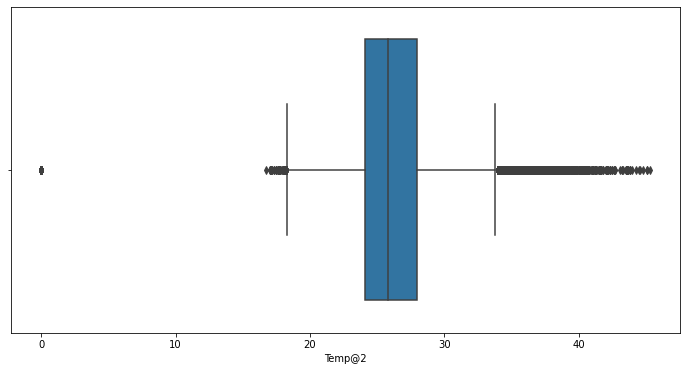

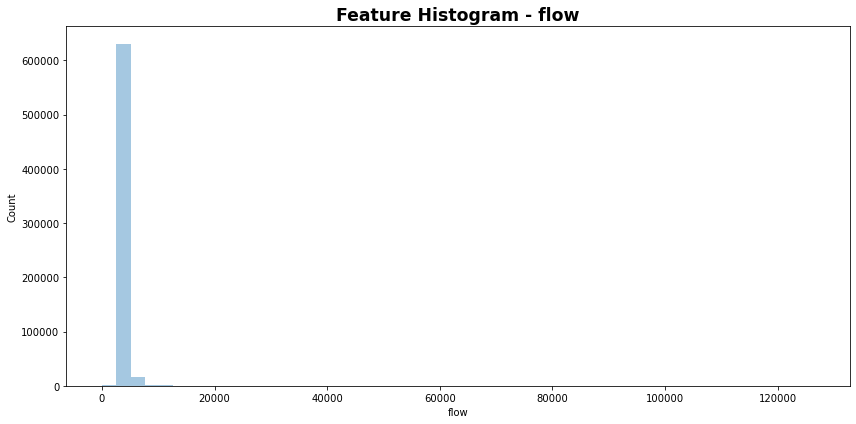

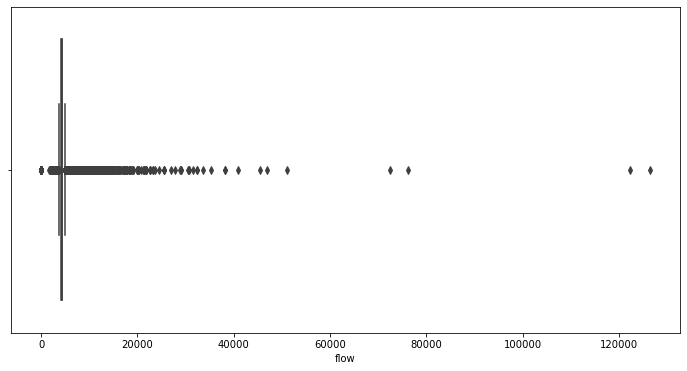

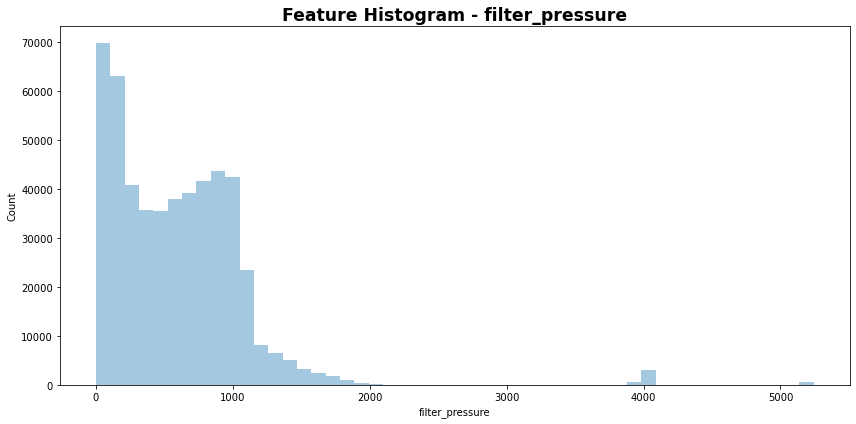

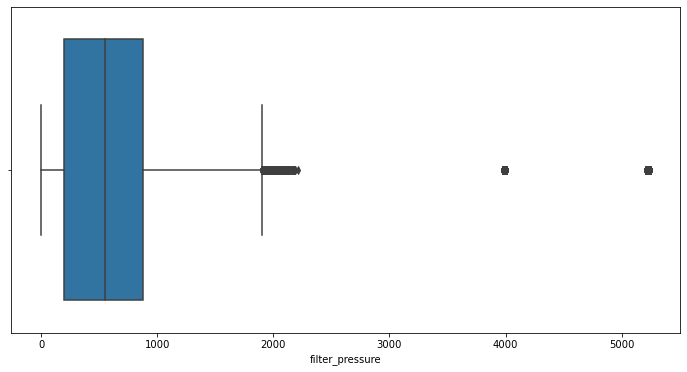

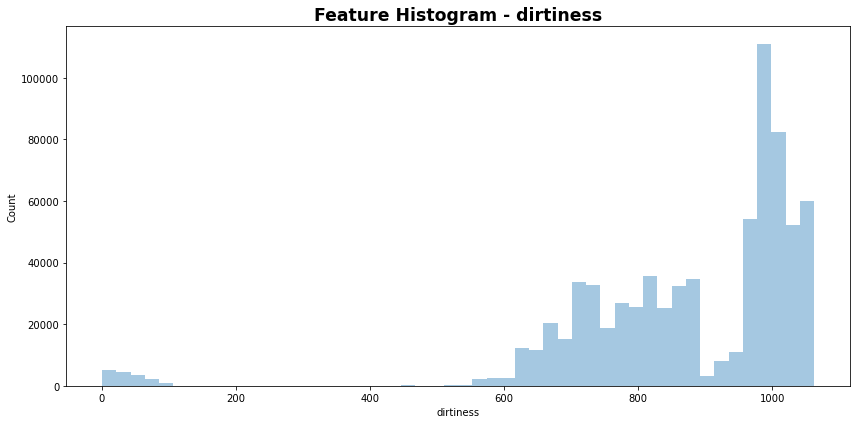

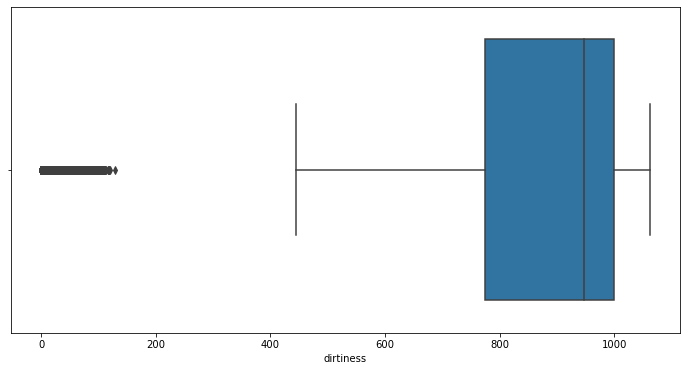

In [8]:
num_features = ["Temp@1","Temp@2","flow","filter_pressure","dirtiness"]
for feature in num_features:
#devide for economic 
    plt.figure(figsize=(12, 6))
    sns.distplot(df_Param[feature].dropna(),kde=False)
    plt.title("Feature Histogram - " + feature,fontsize='xx-large', fontweight='bold')
    plt.ylabel("Count")
    plt.xlabel(feature)
    plt.tight_layout()
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_Param[feature])

**Outliers are defined as 1.5 x Q3 value (75th percentile)**
- Temperautres @ 1 & 2 below 10C are seems not realistic for press, therefore they are considers as outliers
- Dirtiness below 200 is also considers too far from minimum percentile. **I don't have much information about realistic values of dirtiness**
- flow feature beyond 8000 may be machine fault and too far from maximum percentile. Flow must be more than 0 to operate
- Filter pressure beyond 2500 may be machine fault and too far from maximum percentile. Pressure must be more than 0 to operate

In [9]:
df_Param = df_Param.drop(df_Param[df_Param["Temp@1"] < 10].index)
df_Param = df_Param.drop(df_Param[df_Param["Temp@2"] < 10].index)
df_Param = df_Param.drop(df_Param[df_Param["dirtiness"] < 200].index)
df_Param = df_Param.drop(df_Param[df_Param["filter_pressure"] > 2500].index)
df_Param = df_Param.drop(df_Param[df_Param["flow"] > 8000].index)
df_Param = df_Param.drop(df_Param[df_Param["flow"] < 2000].index)
print("# of deleted rows:",Param_length-len(df_Param))

# of deleted rows: 23192


In [10]:
df_Param.describe()

,Press Number,Temp@1,Temp@2,flow,dirtiness,filter_pressure
count,7.090650e+05,709065.000000,709065.000000,637349.000000,709065.000000,500514.000000
mean,9.266665e+08,28.892826,26.165169,4257.335858,893.147965,565.652973
std,2.219061e+06,2.037297,2.988793,423.771982,130.167668,391.700534
min,9.210000e+08,13.100000,16.700000,2118.000000,445.000000,0.000000
25%,9.240004e+08,27.500000,24.100000,4086.000000,785.000000,194.000000
50%,9.280003e+08,28.300000,25.700000,4248.000000,956.000000,543.000000
75%,9.283000e+08,29.900000,27.800000,4398.000000,1001.000000,870.000000
max,9.285015e+08,40.300000,45.300000,7998.000000,1062.000000,2210.000000


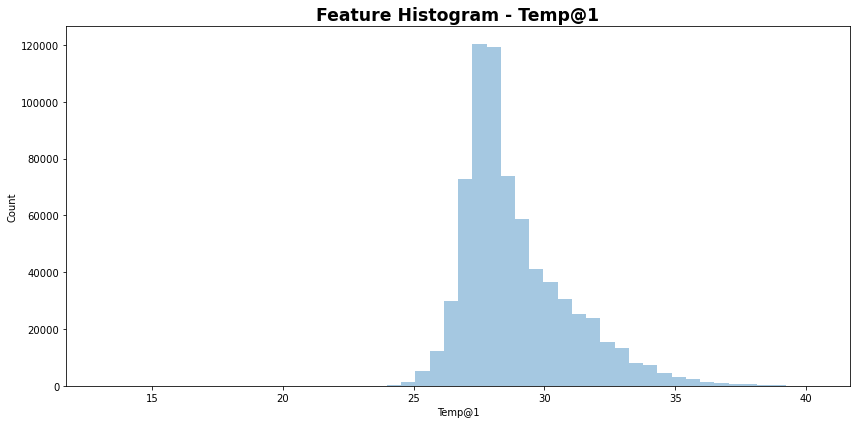

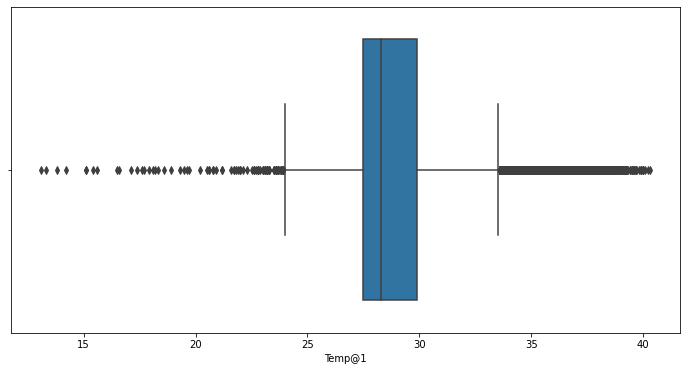

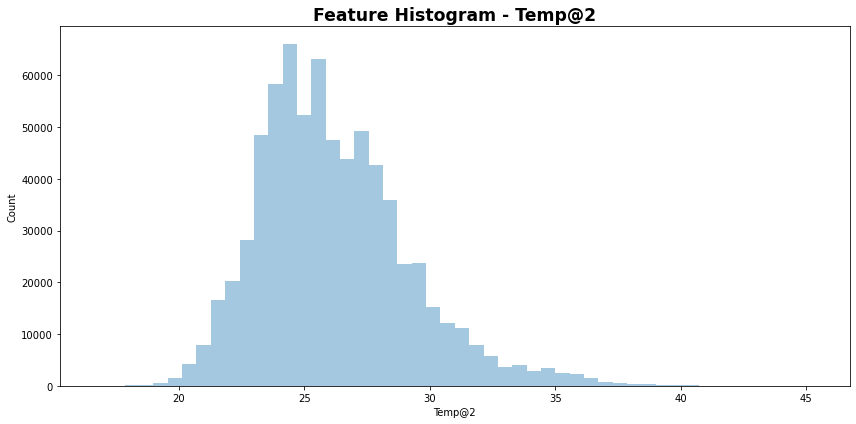

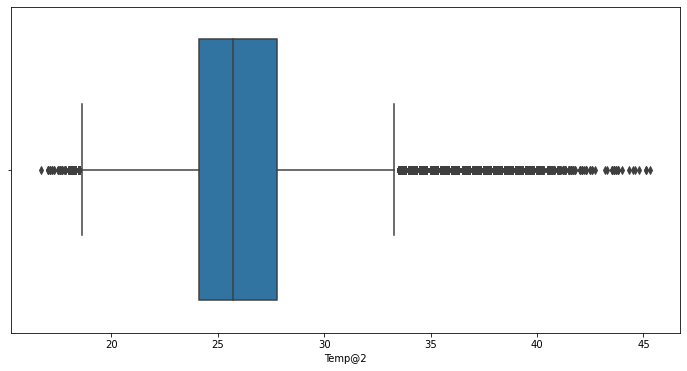

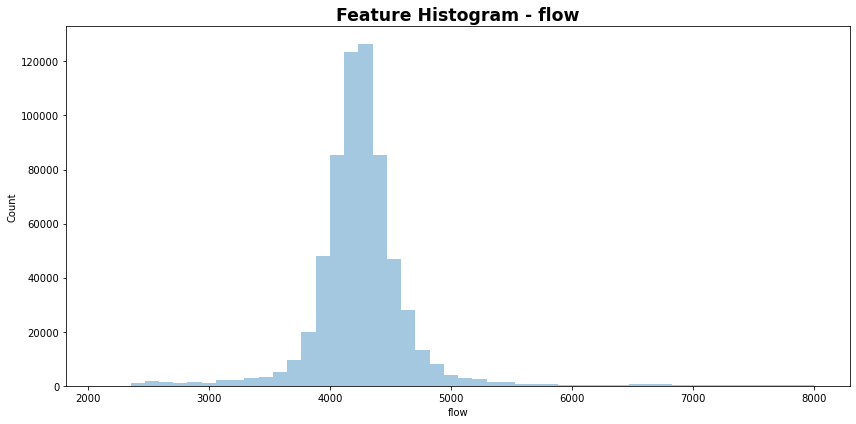

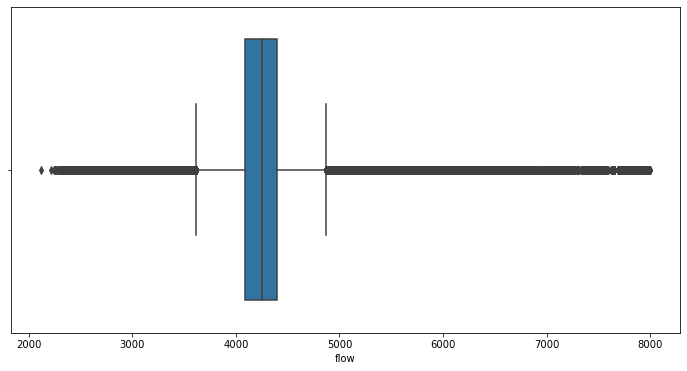

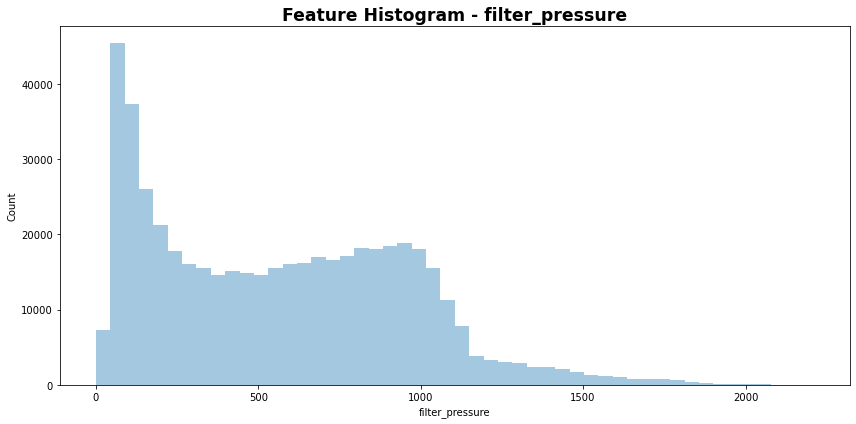

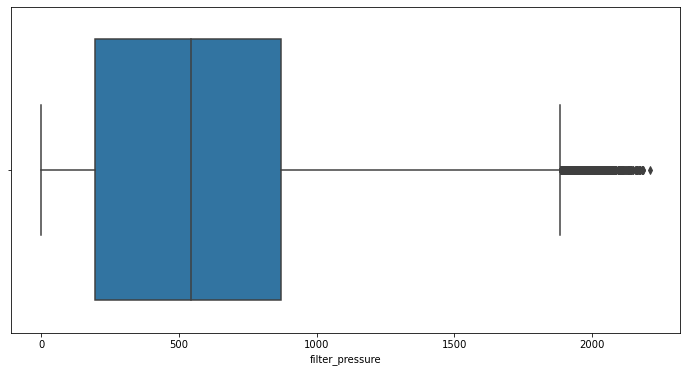

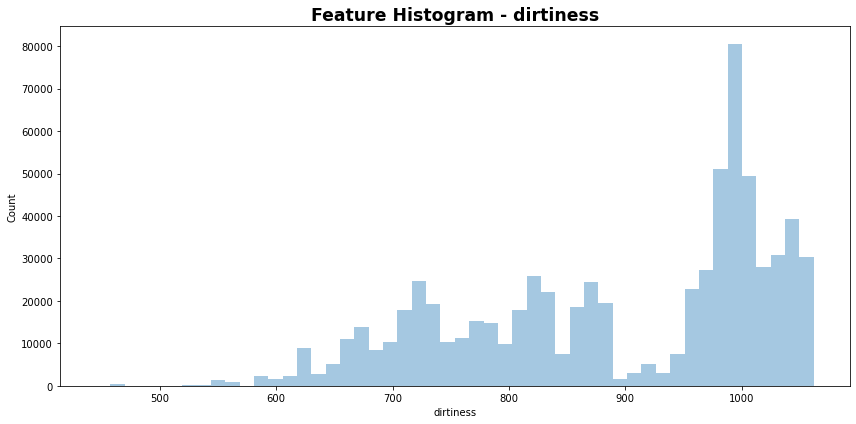

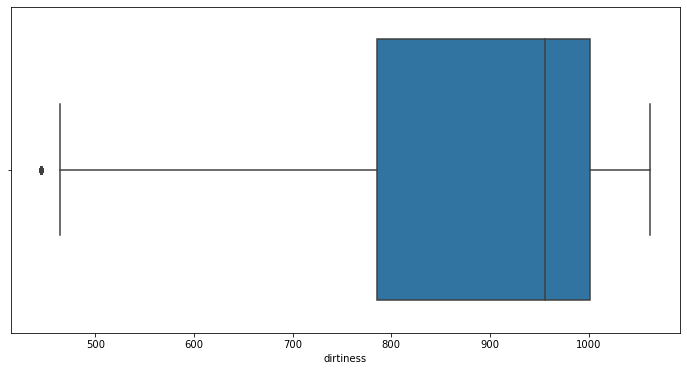

In [11]:
for feature in num_features:
#devide for economic 
    plt.figure(figsize=(12, 6))
    sns.distplot(df_Param[feature].dropna(),kde=False)
    plt.title("Feature Histogram - " + feature,fontsize='xx-large', fontweight='bold')
    plt.ylabel("Count")
    plt.xlabel(feature)
    plt.tight_layout()
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=df_Param[feature])

For merging the two datasets, I'll test where each event is belonging between install and removal dates

In [12]:
df_Param['event_datetime']=pd.to_datetime(df_Param.event_datetime)
df_LS['Consumable Install_datetime']=pd.to_datetime(df_LS['Consumable Install_datetime'])
df_LS['Consumable Removal_dateTime']=pd.to_datetime(df_LS['Consumable Removal_dateTime'])
#Find event bewween install and removal dates and copy features from LS data
df_Param_c=df_Param.copy()
ID_lst=[] ; pressT_lst=[] ; LS_lst=[]
uniqe_pres=df_Param[df_Param.columns[0]].unique()
for pres_num in uniqe_pres:
    df_LS_pres_num=df_LS.loc[df_LS[df_LS.columns[0]] == pres_num]
    df_Param_pres_num=df_Param.loc[df_Param[df_Param.columns[0]] == pres_num]
    for date_Param in range(len(df_Param_pres_num)):
        event=df_Param_pres_num['event_datetime'].iloc[date_Param]
        instal=df_LS_pres_num.loc[lambda df_LS_pres_num: df_LS_pres_num['Consumable Install_datetime'] < event, :]
        remove=instal.loc[lambda instal: instal['Consumable Removal_dateTime'] > event, :]  
        if remove.empty:
            ID_lst.append(np.nan)
            LS_lst.append(np.nan)
            pressT_lst.append(np.nan)
        else:
            ID_lst.append(remove["Consumable ID"].values[0])
            LS_lst.append(remove["Consumable LS (Printed cycles)"].values[0])
            pressT_lst.append(remove["Press type"].values[0])
df_Param_c["Consumable ID"]=ID_lst
df_Param_c["Consumable LS (Printed cycles)"]=LS_lst
df_Param_c["Press type"]=pressT_lst
df_Param_c=df_Param_c.set_index('Press Number')
df_Param_c.head()

,event_datetime,Temp@1,Temp@2,flow,dirtiness,filter_pressure,Consumable ID,Consumable LS (Printed cycles),Press type
Press Number,,,,,,,,,
921000012,2021-10-03 07:56:53,27.2,28.2,4308.0,803,879.0,P293289,19298.0,1.0
921000012,2021-10-25 10:07:49,27.7,29.1,4248.0,803,1022.0,P300568,13247.0,1.0
921000015,2021-09-01 10:25:17,27.9,26.0,4458.0,674,424.0,P283894,15718.0,10.0
921000015,2021-09-01 10:57:55,27.0,25.6,4410.0,674,426.0,P283894,15718.0,10.0
921000015,2021-09-01 12:14:48,27.1,26.0,4428.0,674,427.0,P283894,15718.0,10.0


2.	Explore the data, clean it, exclude suspicious rows, deal with missing values. Explain in words, code or visualizations what assumptions you checked or steps you took to ensure you’re optimizing your usable data. 


In [22]:
df_Param_c["Consumable ID"]

Press Number
921000012    P293289
921000012    P300568
921000015    P283894
921000015    P283894
921000015    P283894
              ...   
928500175    p069200
928500175    p069200
928500176    P102541
928500182    P372978
928500182    P372978
Name: Consumable ID, Length: 650673, dtype: object

In [13]:
#I'll check in which feature I have nulls
df_Param_c.isna().sum()

event_datetime                         0
Temp@1                                 0
Temp@2                                 0
flow                               71716
dirtiness                              0
filter_pressure                   208551
Consumable ID                      28168
Consumable LS (Printed cycles)     28147
Press type                         28147
dtype: int64

There are more than 200K of missing values for filter pressure.
first I'll try to remove multiple columns with nulls (flow & pressure) which is too complicate to fill null to those values.

In [14]:
df_Param_c=df_Param_c.dropna(subset=['flow', 'filter_pressure'], thresh=1)
df_Param_c=df_Param_c.dropna(subset=["Press type"])
df_Param_c["Press type"]=df_Param_c["Press type"].astype('category')
df_Param_c.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 650673 entries, 921000012 to 928500182
Data columns (total 9 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   event_datetime                  650673 non-null  datetime64[ns]
 1   Temp@1                          650673 non-null  float64       
 2   Temp@2                          650673 non-null  float64       
 3   flow                            611504 non-null  float64       
 4   dirtiness                       650673 non-null  int64         
 5   filter_pressure                 481563 non-null  float64       
 6   Consumable ID                   650659 non-null  object        
 7   Consumable LS (Printed cycles)  650673 non-null  float64       
 8   Press type                      650673 non-null  category      
dtypes: category(1), datetime64[ns](1), float64(5), int64(1), object(1)
memory usage: 45.3+ MB


In [15]:
#fill all the rest with median value
df=df_Param_c.copy()
df=df.drop(["event_datetime","Consumable ID"],axis=1)
df=df.fillna(df.mean())
df.describe()

,Temp@1,Temp@2,flow,dirtiness,filter_pressure,Consumable LS (Printed cycles)
count,650673.000000,650673.000000,650673.000000,650673.000000,650673.000000,650673.000000
mean,28.863819,26.109526,4257.997271,892.441417,565.708964,13847.792335
std,2.013779,2.924637,411.636958,130.800763,336.785309,6984.576801
min,13.100000,16.700000,2118.000000,445.000000,0.000000,110.000000
25%,27.500000,24.100000,4104.000000,784.000000,304.000000,9015.000000
50%,28.300000,25.700000,4248.000000,956.000000,565.708964,12990.000000
75%,29.900000,27.800000,4392.000000,1000.000000,762.000000,17336.000000
max,40.100000,45.300000,7998.000000,1062.000000,2210.000000,48926.000000


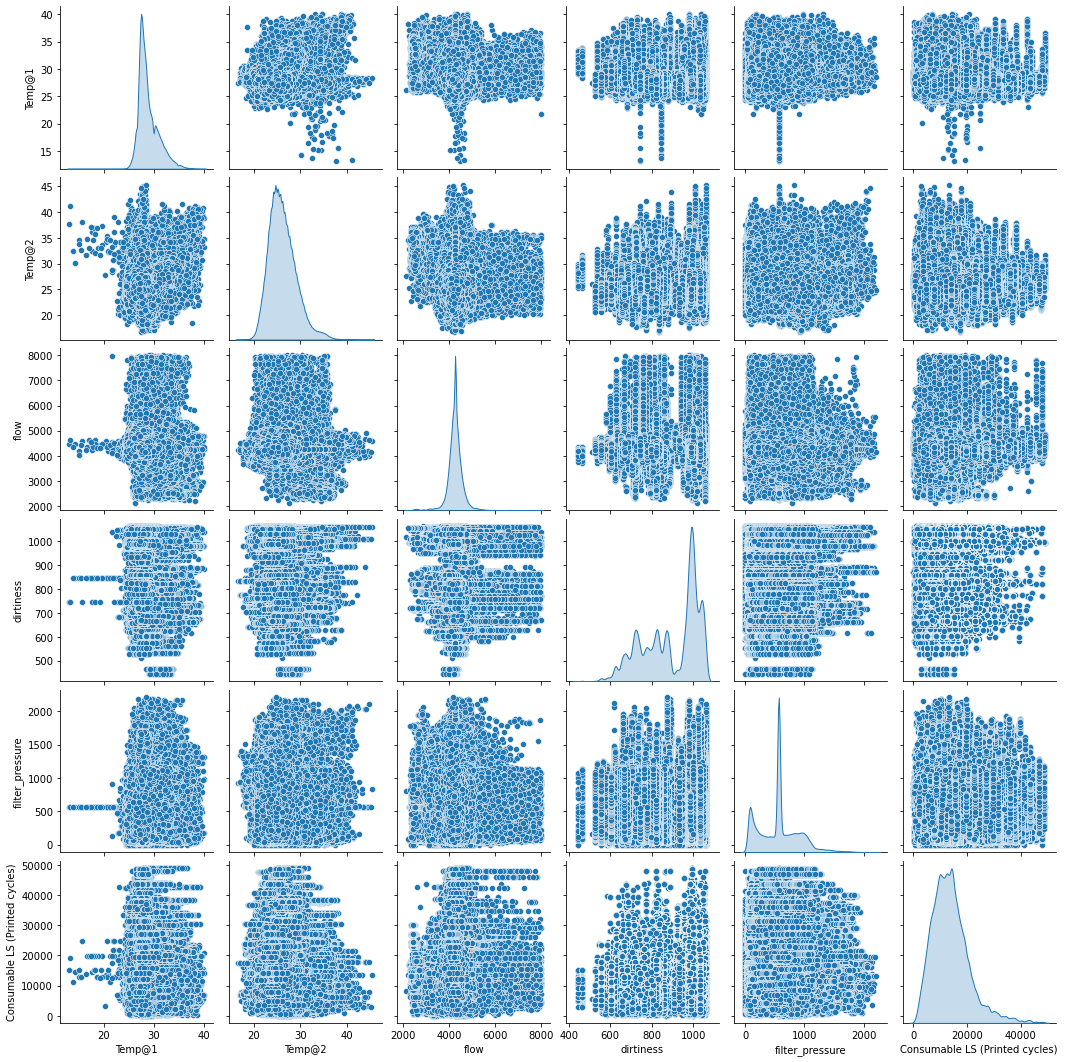

In [16]:
sns.pairplot(df, diag_kind="kde")

Text(0.5, 1.0, 'Correlation Matrix')

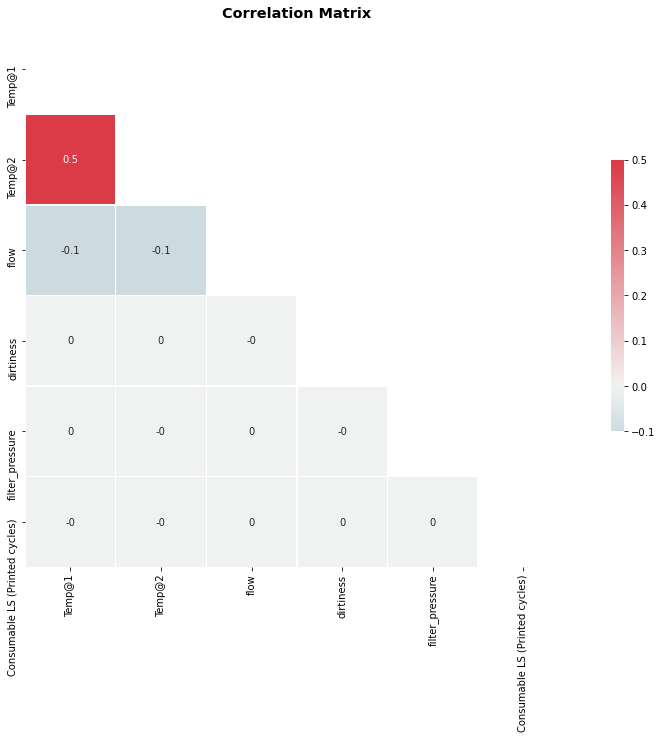

In [17]:
cor = df.corr().round(1)
mask = np.zeros_like(cor, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(15, 10))
heatmap=sns.heatmap(cor,mask=mask,annot=True,annot_kws={"size": 10},
                    center=0,cmap=cmap,square=True, linewidths=.5,
                    cbar_kws={"shrink": .5},yticklabels=1,xticklabels=1)
plt.title("Correlation Matrix", fontsize='x-large', fontweight='bold')

In [18]:
from scipy import stats
z = np.abs(stats.zscore(df))
#define a threshold to identify an outlier
threshold = 3
df_outliers=df[(z < threshold).all(axis=1)]
Num_outliers=df.shape[0]-df_outliers.shape[0]
print("outliers by each feature boxplot: "+str(Num_outliers))
from sklearn.neighbors import LocalOutlierFactor
# fit the model for outlier detection (default)
n_outliers = Num_outliers
ground_truth = np.ones(len(df), dtype=int)
ground_truth[-n_outliers:] = -1
LOF = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
# use fit_predict to compute the predicted labels of the training samples
# (when LOF is used for outlier detection, the estimator has no predict,
# decision_function and score_samples methods).
y_pred = LOF.fit_predict(df)
n_errors = (y_pred != ground_truth).sum()
X_scores = LOF.negative_outlier_factor_
LOF_outliers=np.count_nonzero(y_pred == -1)
LOF_outliers_percentage=round(100*np.count_nonzero(y_pred == -1)/df.shape[0],0)
print("Number of outliers by LOF is "+str(LOF_outliers)+ ", Noise accounts for "+str(LOF_outliers_percentage)+"%  of the total dataset" )

outliers by each feature boxplot: 40362
Number of outliers by LOF is 65068, Noise accounts for 10.0%  of the total dataset


3.	Create a new data set in which each Consumable ID has 1 row. Create as many meaningful  features as you can from the data provided in this dataset. 


In [19]:
df=df_outliers
y=df["Consumable LS (Printed cycles)"]
print("max cycles:",max(y))
print("min cycles:",min(y))
y_labeles=['0-5000','5000-7500','7500-9500', '9500-12000', '12000-'+str(int(max(y)+1))]
y_bins=[0, 5000,7500,9500, 12000,max(y)+1]
y_bins = pd.cut(y, y_bins, labels=y_labeles)
y_bins.head()

max cycles: 34784.0
min cycles: 110.0


Press Number
921000012    12000-34785
921000012    12000-34785
921000015    12000-34785
921000015    12000-34785
921000015    12000-34785
Name: Consumable LS (Printed cycles), dtype: category
Categories (5, object): ['0-5000' < '5000-7500' < '7500-9500' < '9500-12000' < '12000-34785']

4.	Fit several models and compare their performance.


Text(0, 0.5, 'Cumulative explained variance')

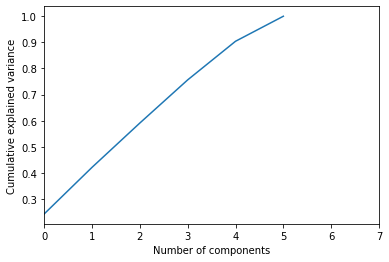

In [20]:
X=df.drop(["Consumable LS (Printed cycles)"],axis=1)
X_Train=X.values
X_Train=np.asarray(X_Train)

# Finding normalised array of X_Train
X_std=StandardScaler().fit_transform(X_Train)
pca = PCA().fit(X_std)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlim(0,7,1)
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Since 3 components can explain more than 70% of the variance and there is coralation between Temp@1 with Temp@2, I'll use Temp@avg to lower number of features. Hence, I have 4 features (because I'm not sure if I can lower more the parameters by unite other columns)

In [21]:
X['Temp@avg'] = X[['Temp@1', 'Temp@2']].mean(axis=1)
X=X.drop(['Temp@1', 'Temp@2'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y_bins, test_size=0.25, random_state=0)
print('Training data shape: ', X_train.shape)
print('Testing data shape : ', X_test.shape)

Training data shape:  (457733, 5)
Testing data shape :  (152578, 5)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

dfs = []
models = [
          ('LogReg', LogisticRegression()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
target_names = y_train.unique()
for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
        results.append(cv_results)
        names.append(name)
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

LogReg
               precision    recall  f1-score   support

    7500-9500       0.00      0.00      0.00     10093
12000-34784.0       0.56      1.00      0.72     85294
   9500-12000       0.00      0.00      0.00     16050
   110.0-5000       0.00      0.00      0.00     16962
    5000-7500       0.15      0.00      0.00     24179

     accuracy                           0.56    152578
    macro avg       0.14      0.20      0.14    152578
 weighted avg       0.34      0.56      0.40    152578

RF
               precision    recall  f1-score   support

    7500-9500       0.48      0.36      0.41     10093
12000-34784.0       0.74      0.87      0.80     85294
   9500-12000       0.44      0.35      0.39     16050
   110.0-5000       0.42      0.33      0.37     16962
    5000-7500       0.47      0.37      0.41     24179

     accuracy                           0.64    152578
    macro avg       0.51      0.45      0.48    152578
 weighted avg       0.61      0.64      0.62    15

In [ ]:
bootstraps = []
for model in list(set(final.Model.values)):
    model_df = final.loc[final.Model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

5. Present your results and concluding insights with respect to the question posed. 

## Important Notes
- If you realize that steps 4 and 5 are more time demanding than the time permits, you can summarize your planned actions without implementing them in a script
- You can call us and ask as many questions as you need to understand the problem. 
- Alexandra 050-7445553, Tova 050-6913288
